# Обучение сверточной нейросети на датасете HAM10000

## Импорт необходимых библиотек 

In [1]:
# General
import numpy as np
import matplotlib.pyplot as plt
# PyTorch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch
import torch.optim as optim
# classic ML
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

In [32]:
img_size = 256
num_epochs = 5
batch_size = 10
learning_rate = 0.001

## Перевод изображений в тензоры

Все изображения изначально поделены на папки **train** и **test**. 
В каждой папке изображения лежат по папкам классов. 
На 1 класс одна папка. 
Количество представителей каждого из классов распределены в одинаковых пропорциях в train и test выборке. 
Про то как производилось распределение подробно в [блокноте](https://github.com/gurmaaan/MedNN/blob/master/Sort_img_into_folders.ipynb)

Определяем каскад трансформаций, который будут осуществляться над каждым изображением выборки перед попаданием на обучение / тестирование нейронной сети.

Каскад - массив трансформаций, каждая из которых будет применена к изображению последовательно одна за одной.
Каскад реализуется с помощью _Compose_.
* ToTensor - конвертирует изображение в Тензор 
* Normalize - приводит тензор к нормальному распределению со матожиданием ... и СКО ... МО и СКО указываются для каждой компоненты пикселя 

In [33]:
transformation = [
    transforms.Resize(size=(img_size,img_size)),
    transforms.ToTensor()
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
]
transformation

[Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR), ToTensor()]

Ниже игрушечный пример как работает трансформация изображений

In [34]:
# from PIL import Image
# img = Image.open('image32x32.jpg')
# # d_t = transforms.Compose(transformation)(img)
# d_t = transforms.ToTensor()(img)
# # d_t[компонента цвета][номер столбца в изображении (координата х)] - содержит в себе массив преобразованных координат y данной строки
# len(d_t[0][0])

Теперь дадим понять torch'у к каким изображениям применять описанную выше трансформацию и к каким классам относятся изображения.
Для этого используется класс ImageFolder.
Он загружает папку в которой изображения распиханы по классам-папкам как описано выше. 
```
/root/class1/11.jpg
/root/class1/12.jpg
/root/class2/21.jpg
/root/class2/22.jpg
```

In [35]:
train_folder = ImageFolder(root='train', transform=transforms.Compose(transformation))
test_folder = ImageFolder(root='test', transform=transforms.Compose(transformation))

Теперь я могу узнать размер выборки, распределение по классам, сами классы и т.д.

In [36]:
class_labels = list(train_folder.classes)
num_classes = len(class_labels)
class_labels

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [37]:
len(train_folder)

6710

После этого превратим наши изображения в тренировочную и тестовую выборки для будущей нейросети. 
Для этого используется класс DataLoader.
Он позволяет выдавать случайные выборки и многое другое. 
Выжный параметр деления всей тренировочной выборки на группы:
* batch_size - сколько изображений содержится в 1 группе

In [38]:
train_loader = DataLoader(train_folder, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_folder, batch_size=batch_size, shuffle=True)

len(test_loader) - показывает количество итераций, т.е. сколько батчей во всей выборке
Например, обучающая выборка 6710 фотографий. Размер батча = 100. Тогда итераций будет 6710 / 100 = 68 (т.к. остаются несчастные 10шт в конц) 

In [39]:
stat_out = round(len(train_loader) / 5)
stat_out

134

In [40]:
# for ti, tl in test_loader:
#     print(len(ti[0][0]), tl[0])

**Посмотрим что содержится в одном батче**

In [41]:
train_iter = iter(train_loader)

In [42]:
train_images, train_labels = train_iter.next()

In [43]:
classes = train_folder.class_to_idx
classes_map = dict((v,k) for k,v in classes.items())

In [44]:
def label_encoder(class_dict, labels):
    print('Labels:', ' | '.join('%5s' % class_dict[l.item()] for l in labels))

In [45]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(16, 16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

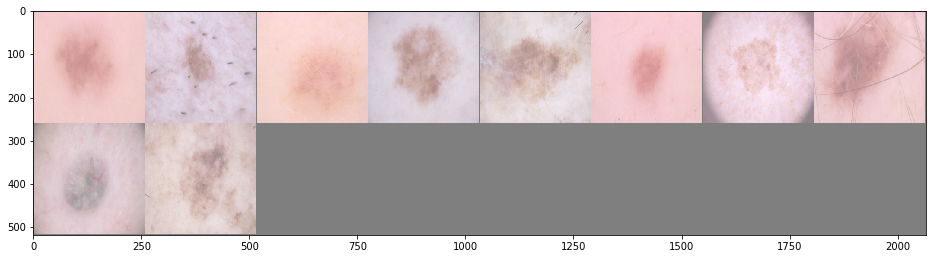

Labels: nevus | nevus | nevus | melanoma | pigmented benign keratosis | nevus | pigmented benign keratosis | nevus | basal cell carcinoma | pigmented benign keratosis


In [46]:
imshow(torchvision.utils.make_grid(train_images))
label_encoder(classes_map, train_labels)

## Понимание что происходит с размерами

In [47]:
train_images.size()

torch.Size([10, 3, 256, 256])

**Conv2d(3, 6, 5)**

3 = число каналов во входном изображении. 
Например, было 3 компоненты цвета R G B поэтому и каналов 3 .
Это первая компонента размера трехмерного тензора.
Менять нельзя.

6 = число каналов в выходном изображении. Я та ки не понял зачем его увеличивают

5 = размер свертки которой проходятся. Т.е. 5х5 квадратик ползает по изображению и применяет формулу [Cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation)


**MaxPool2d(2,2)**

Первый параметр = размер квадратика которым проходят 

Второй параметр = шаг через который идет квадратик. 

Суть в том что вот квадратик 2х2 проходит, т.е. в нем 4 пикселя. И он выбирает из этих 4 тот у которого значенеи яркости ( или компоненты) наибольшее. И далее формирует новое изображение (тензор) уже другого размера

In [54]:
inp = train_images
print("Input", inp.size())
# print(f"Input tensor: {inps[0]} items where {inps[1]} components of {inps[2]} x {inps[3]} images")

c2d = nn.Conv2d(3, 6, 5)
c22d =  nn.Conv2d(6, 16, 5)
mp = nn.MaxPool2d(2,2)
# ln = nn.Linear()
out = mp(F.relu(c2d(inp)))
# out = mp(c2d(inp))
out = mp(F.relu(c22d(out)))
# out = out.view(-1, 16 * 29 * 29)
print("Output", out.size())
# print(f"Output tensor: {outs[0]} items where {outs[1]} components of {outs[2]} x {outs[3]} images")

Input torch.Size([10, 3, 256, 256])
Output torch.Size([10, 16, 61, 61])


## Определение архитектуры нейросети

In [55]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 61 * 61)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [56]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [57]:
net = Net()
net.to(device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=8, bias=True)
)


In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

## Обучаем нейросеть 

In [59]:
%%time
for epoch in range(num_epochs):  # loop over the dataset multiple times
    
    print(f"Epoch {epoch + 1} ------------")
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % stat_out == (stat_out - 1):
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / stat_out}")
            running_loss = 0.0

print('Finished Training')

Epoch 1 ------------
[1, 134] loss: 1.296377771381122
[1, 268] loss: 1.1216744335729685
[1, 402] loss: 1.078839884987518
[1, 536] loss: 1.054030880331993
[1, 670] loss: 1.0647772839709895
Epoch 2 ------------
[2, 134] loss: 1.0165042147707584
[2, 268] loss: 1.0284462895855975
[2, 402] loss: 1.0182462362433546
[2, 536] loss: 0.9980962990380046
[2, 670] loss: 0.8996202574292226
Epoch 3 ------------
[3, 134] loss: 0.9506430181104746
[3, 268] loss: 0.9167953234777522
[3, 402] loss: 1.0209273880542213
[3, 536] loss: 0.8864838734491548
[3, 670] loss: 1.013130611670551
Epoch 4 ------------
[4, 134] loss: 0.9249647780140834
[4, 268] loss: 0.9331307247725885
[4, 402] loss: 0.9090225345163203
[4, 536] loss: 0.9583751484751701
[4, 670] loss: 0.9192788910065124
Epoch 5 ------------
[5, 134] loss: 0.9098545489693756
[5, 268] loss: 0.9148265648244033
[5, 402] loss: 0.8808507014121583
[5, 536] loss: 0.9203149331594581
[5, 670] loss: 0.8971794659077231
Finished Training
Wall time: 7min 43s


## Сохранение выученных коэффициентов

In [ ]:
coeff_path = f"nn_coeffs/no_changes_in_data/own_cnn_{img_size}x{img_size}.pth"
torch.save(net.state_dict(), coeff_path)

## Проверка нейросети на способность предсказания

Сначала грузим реальные картинки и метки классов

In [ ]:
test_iter = iter(test_loader)

In [ ]:
test_images, test_labels = test_iter.next()

In [ ]:
imshow(torchvision.utils.make_grid(test_images))
label_encoder(classes_map, test_labels)

Теперь смотрим что угадает сеть

In [ ]:
net = Net()
net.load_state_dict(torch.load(coeff_path))

In [ ]:
outputs = net(test_images)

In [ ]:
_, prediction = torch.max(outputs, 1)
label_encoder(classes_map, prediction)

## Оценка accuracy

In [60]:
%%time

result_dict = {
    "real" : [],
    "predicted" : []
}

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(labels)):
            result_dict["real"].append(classes_map[labels[i].item()])
            result_dict["predicted"].append(classes_map[predicted[i].item()])

result_df = pd.DataFrame(result_dict)
result_df["answer"] = result_df.apply(lambda x: int(x["real"] == x["predicted"]), axis=1)

total_acc = accuracy_score(result_df["real"], result_df["predicted"]) * 100
print(f"Total accuracy: {round(total_acc, 2)}%")
print("---------------------")

for img_class in result_df["real"].unique():
    class_df = result_df[result_df["real"] == img_class]
    class_acc = accuracy_score(class_df["real"], class_df["predicted"]) * 100
    print(f"{img_class} ({len(class_df)}) : {round(class_acc, 2)}%")

Total accuracy: 67.38%
---------------------
nevus (2226) : 92.09%
pigmented benign keratosis (343) : 18.08%
dermatofibroma (33) : 0.0%
basal cell carcinoma (165) : 57.58%
melanoma (396) : 5.05%
actinic keratosis (37) : 0.0%
squamous cell carcinoma (60) : 0.0%
vascular lesion (45) : 0.0%
Wall time: 42.2 s


In [ ]:
# result_df.to_csv('result.csv', index=False)